## BeamformerEA demo notebook
This notebook demonstartes the use of the BeamformerEA acoular class. The BeamformerEA reconstructs 
an acoustic field using monopole sound sources. Unlike the other beamformer in acoular, it uses a variable grid to reconstruct the sources. It can correctly find the positions and the source strengths. To achieve this goal, a global optimization problem is solved using the evolutionary algorithm differential evolution from the scipyt.optimice python package. 

Below is a synthetic data set with a monopole acoustic source evaluated with BeamformerEA, BeamformerBase and BeamformerCMF. The monoopole source shall be positioned at x_s = 0.5, y_s = 0.0, z_s = 0.75 with a rms amplitude of 1.0 in 1 m distance. The variable search gird for the source shall be defined on the x,y - surface with bounds:  x = [-1.0, 1.0] y = [-1.0, 1.0] z = [0.75, 0.75] d = [0.0, 1.0]. Where d are the bounds for the source strength 

In [1]:
from acoular import *
from os import path
from acoular import __file__ as bpath
import matplotlib.pyplot as plt

# load some array geometry
micgeofile = path.join(path.split(bpath)[0], 'xml', 'array_64.xml')
MICGEOM = MicGeom(from_file=micgeofile) 

# set sampling frequency and singal time 
SFREQ = 51200
TIME = 1
NUM_SAMPLES = TIME * SFREQ
BLOCK_SIZE = 128

# create some exemplary synthetic data of one monopole point source
# with white noise signal. 
h5savefile = 'Test_dat.h5'
n = WNoiseGenerator(sample_freq=SFREQ, numsamples=NUM_SAMPLES, seed=0)
p = PointSource(signal=n, mics=MICGEOM, loc=(0.5,0.0,0.75))
wh5 = WriteH5(source=p, name=h5savefile)
wh5.save()

## BeamformerEA

In [49]:
# Define boundary for source position and source strength variation.
# The amount of monopole sources used for the reconstruction is defined by the 
# length of the GRID_BOUNDS array, which has to be a multiple of 4.  
# The amount of sources used for the reconstruction is then len(GRID_BOUNDS)/4.
# GRID_BOUNDS = [(x_s1l, x_s1r),(y_s1l, y_s1r),(z_s1l, z_s1r),(d1l, d1r), ...]
# where x_s1l, x_s1r are the lower and upper bounds for the positional variation of source one
# and d1l, d1r are the bounds for its source strength variation.
# In our example we want to search for the source position and source strength in 
# the x,y plane at the fixed height z = 0.75.Therefore the third tuple contains (0.75,0.75)
# We want to use only one source, so our GRID_BOUDS is the following array:
GRID_BOUNDS = [(-1., 1.), (-1., 1.), (0.75, 0.75), (0., 1.)]
# The BeamformerEA requires an MicGeom object, an PowerSpectra object and a GRID_BOUNDS array 
# for source reconstruction. In order to avoid deprecation warnings the MicGeom object will be
# passed through the SteeringVector object, which may change in the future.

SV_EA = SteeringVector(mics=MICGEOM, grid=GR) 
ts = TimeSamples(name='Test_dat.h5', sample_freq=SFREQ)
ps = PowerSpectra(time_data=ts, block_size=BLOCK_SIZE, window='Hanning')
bea = BeamformerEA(steer = SV_EA, freq_data=ps)

In [50]:
# set bounds automaticly sets number of sources n
bea.bounds = [(-1., 1.), (-1., 1.), (0.75, 0.75), (0., 1.)]*2

In [51]:
# reconstructs the sound pressure field in all small band frequencies 
# this calculation takes some (time 10 min with 1 source, 30 min with 2 sources)
res_BEA = bea.synthetic(800, 0)

[('Test_dat_cache.h5', 6)]
[('Test_dat_cache.h5', 7)]
calculating frequency:  400.0
0.0021999792087625814
0.017547435462324068
calculating frequency:  800.0
0.012233094697912616
0.0065121923515870095
calculating frequency:  1200.0
0.009884100985809274
0.008627075598940492
calculating frequency:  1600.0
0.008283888946907347
0.010611539072861775
calculating frequency:  2000.0
0.010731322079669758
0.00887483925528254
calculating frequency:  2400.0
0.008462313786315234
0.010057810945542534
calculating frequency:  2800.0
0.008242771265677684
0.009074237709700617
calculating frequency:  3200.0
0.00894843231503134
0.009843580339523317
calculating frequency:  3600.0
0.01058968842472513
0.009489298647046673
calculating frequency:  4000.0
0.009317152083208768
0.011542331849243803
calculating frequency:  4400.0
0.008978065435468974
0.00849942815528032
calculating frequency:  4800.0
0.01100367716538514
0.008313040502065994
calculating frequency:  5200.0
0.012125776212596695
0.009001296222036659
ca

In [52]:
print(bea._gpos[0,:10])
print(bea._gpos[1,:10])
print(bea._gpos[2,:10])

[ 0.          0.         -0.26923386  0.59881927  0.64698803  0.27236614
  0.63069012  0.37962584  0.40139835  0.59353665]
[ 0.00000000e+00  0.00000000e+00 -2.58092953e-03 -2.51792961e-04
  1.20906160e-03 -2.57590816e-03  4.16848333e-04 -8.02620737e-04
 -3.16053878e-05  8.15412379e-06]
[0.   0.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


(-1.0, 1.0)

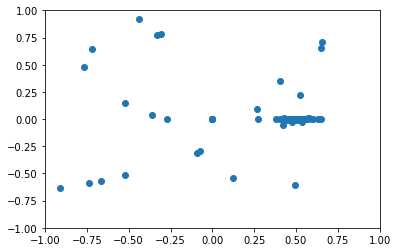

In [57]:
plt.scatter(bea._gpos[0,::],bea._gpos[1,::])
plt.xlim(-1,1)
plt.ylim(-1,1)

In [56]:
L_p(sum(res_BEA))

76.70832103899558

# Old way to use BeamformerEA

     fun: 0.0033918981056006805
 message: 'Optimization terminated successfully.'
    nfev: 1635
     nit: 26
 success: True
       x: array([ 4.93305995e-01, -7.09066006e-05,  7.50000000e-01,  1.81392047e-02])
76.56558250579198


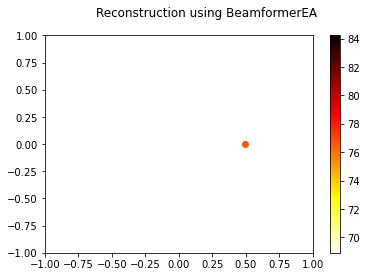

In [36]:
# The main BeamformerEA method which calculates source position and 
# source strengths on a variable Grid defined by GRID_BOUNDS in
# the narrow band with frequency 800 Hz. 
res_BEA = bea.calculate(GRID_BOUNDS, 800)

# The BeamformerEA calculate method returns an scipy.optimize.OpimizeResult object, 
# in which x contains the found coordinates and strength of the sources used for reconstruction.
# In our exemplary case this would be: 
# res_BEA.x[0] - x - coordinate  source 1
# res_BEA.x[1] - y - coordinate  source 1
# res_BEA.x[2] - z - coordinate  source 1
# res_BEA.x[3] - source strength source 1
print(res_BEA)

# For the graphical representation of the results only one point has to be plotted, 
# which can be achieved with pyplot.scatter.
plt.figure()
plt.scatter(res_BEA.x[0],res_BEA.x[1],c=L_p(res_BEA.x[3]),cmap= 'hot_r')
plt.suptitle("Reconstruction using BeamformerEA")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.colorbar()

print(L_p(res_BEA.x[3]))

As can be seen, the BeamformerEA finds the the source in the correct position. 

# BeamformerGridlessOrth

In [43]:
GR = RectGrid(x_min=-1,x_max=1, y_min=-1, y_max=1, z=0.75,increment=0.1)
SV = SteeringVector(grid=GR, mics=MICGEOM)
bgo = BeamformerGridlessOrth(freq_data=ps,steer=SV, bounds=[(-1.,1.),(-1.,1.),(0.74,0.75)])
bgo.n = 1

res_bgo = bgo.synthetic(1600,0)

[('Test_dat_cache.h5', 5)]


In [44]:
print(bgo._gpos[0,:10])
print(bgo._gpos[1,:10])
print(bgo._gpos[2,:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [45]:
res_bgo

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

(-1.0, 1.0)

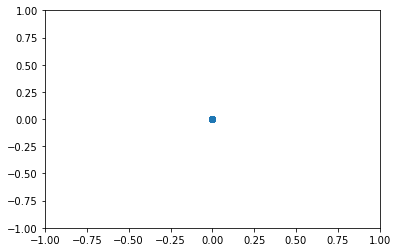

In [46]:
plt.scatter(bgo._gpos[0,:10],bgo._gpos[1,:10])
plt.xlim(-1,1)
plt.ylim(-1,1)

## BeamformerBase

In [ ]:
#define grid and steering vector for BeamformerBase and BeamformerCMF
GR = RectGrid(x_min=-1,x_max=1, y_min=-1, y_max=1, z=0.75,increment=0.1)
SV = SteeringVector(grid=GR, mics=MICGEOM)

beb = BeamformerBase(freq_data=ps,steer=SV)
res_BEB = beb.synthetic(800,0)

im = plt.imshow(L_p(res_BEB.T),vmax=70,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerBase")
plt.colorbar()

## BeamformerCMF

In [ ]:
#becmf = BeamformerCMF(freq_data=ps,grid=GR, mpos=MICGEOM)
becmf = BeamformerCMF(freq_data=ps,steer=SV)
res_CMF = becmf.synthetic(800,0)

im = plt.imshow(L_p(res_CMF.T),vmax=70,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerCMF")

plt.colorbar()

The results from BeamformerBase and BeamformerCMF are close to BeamformerEA, source position and strength are similar. Nevertheless the results are only conditionally comparable, because the BeamformerEA uses a variable grid.  